In [48]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
import torch
from datasets import load_dataset
from PIL import Image
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast
from wavelet_spectrogram import cwt_spectrogram
import itertools
import os


In [49]:
dataset = load_dataset("DavidVivancos/MindBigData2022_MNIST_IN")
list(dataset["train"][0].items())[:8]


[('label', 6),
 ('AF3-0', 4284.102564),
 ('AF3-1', 4281.073718),
 ('AF3-2', 4296.923077),
 ('AF3-3', 4312.588141),
 ('AF3-4', 4318.141025),
 ('AF3-5', 4314.20673),
 ('AF3-6', 4296.65064)]

In [50]:
channels = sorted(set(map(lambda x: x.split("-")[0], dataset["train"][0].keys())) - {'label'})
channels


['AF3', 'AF4', 'PZ', 'T7', 'T8']

In [51]:
# B, C, H, W
C = len(channels)
H, W = 168, 256
L = 256
S = max(H, W)


In [52]:
map_digit_to_token = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}


In [53]:
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")


In [54]:
def preprocess(inputs, return_loss=True):
  labels = [map_digit_to_token[label] for label in inputs["label"]]
  tokenized_labels = tokenizer(labels, padding=True, return_tensors="pt")
  inputs["input_ids"] = tokenized_labels.input_ids
  inputs["attention_mask"] = tokenized_labels.attention_mask
  B = len(inputs["label"])
  samples = np.zeros((B, C, S, S))
  for b in range(B):
    for i, channel in enumerate(channels):
      sample = np.array([inputs[f"{channel}-{j}"][b] for j in range(L)])
      power, *_ = cwt_spectrogram(sample, 120, nNotes=24, detrend=True, normalize=True)
      samples[b, i, :min(H, S), :min(W, S)] = power.squeeze()
  inputs["pixel_values"] = samples
  return inputs


In [55]:
item = preprocess(dataset["train"][:8])
item["label"], item["input_ids"], item['pixel_values'].shape


([6, 6, 6, 4, 0, 7, 0, 2],
 tensor([[49406,  4093, 49407],
         [49406,  4093, 49407],
         [49406,  4093, 49407],
         [49406,  2721, 49407],
         [49406,  5848, 49407],
         [49406,  5757, 49407],
         [49406,  5848, 49407],
         [49406,  1237, 49407]]),
 (8, 5, 256, 256))

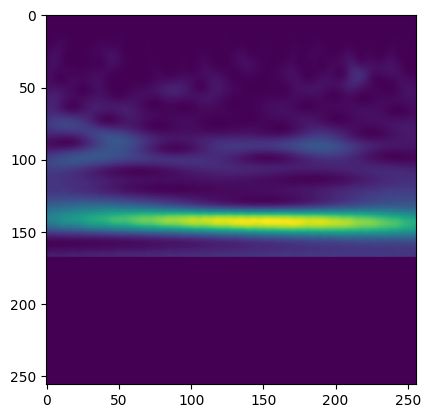

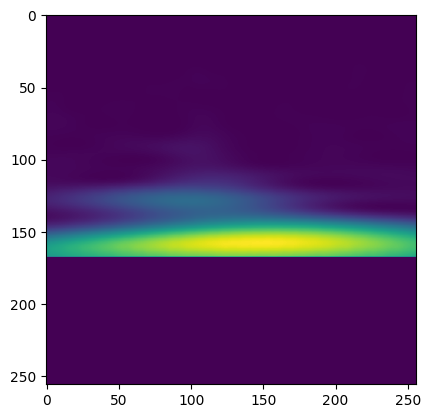

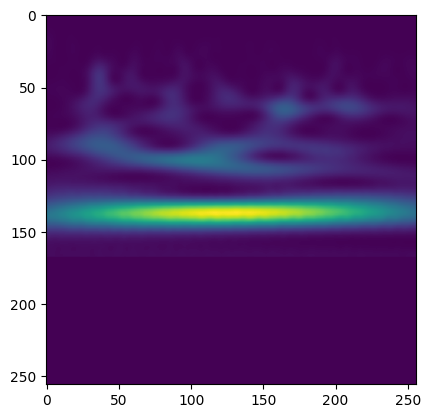

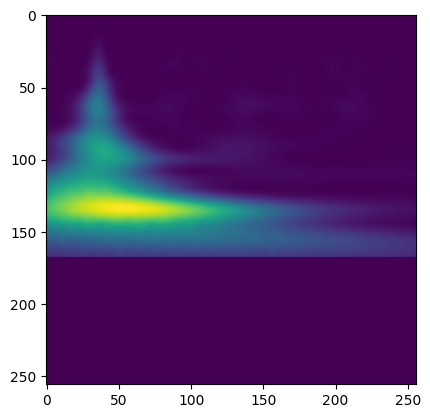

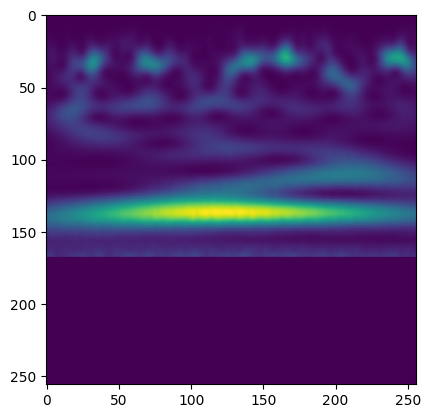

In [56]:
item["pixel_values"][0]

for c in range(C):
    plt.imshow(item["pixel_values"][0][c])
    plt.show()


In [9]:
remove_columns = [f"{channel}-{i}" for channel, i in itertools.product(channels, range(L))] + ["label"]


In [10]:
preprocessed_dataset = dataset.map(preprocess, batched=True, remove_columns=remove_columns, num_proc=24)


Map (num_proc=24): 100%|██████████| 2614/2614 [00:09<00:00, 269.48 examples/s] 


In [11]:
from transformers import CLIPVisionConfig, CLIPVisionModelWithProjection, CLIPModel, CLIPProcessor


In [12]:
configuration = CLIPVisionConfig(
    image_size=max(H, W),
    num_channels=C,
    num_hidden_layers=6,
)
vision_model = CLIPVisionModelWithProjection(configuration)


In [13]:
from typing import Optional, Tuple, Union


import torch
from transformers.models.clip.modeling_clip import CLIPOutput
from transformers.models.clip.modeling_clip import CLIP_INPUTS_DOCSTRING, CLIPConfig
from transformers.utils import (
    ModelOutput,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)

class TrainableCLIPModel(CLIPModel):
    @add_start_docstrings_to_model_forward(CLIP_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=CLIPOutput, config_class=CLIPConfig)
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        return_loss: Optional[bool] = True,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, CLIPOutput]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, CLIPModel

        >>> model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        >>> processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(
        ...     text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
        ... )

        >>> outputs = model(**inputs)
        >>> logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        >>> probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        ```"""
        return super().forward(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            position_ids=position_ids,
            return_loss=return_loss,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )


In [31]:
model = TrainableCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [33]:
model.vision_model = vision_model.vision_model


In [34]:
for p in model.text_model.parameters():
  p.requires_grad = False
for p in model.text_projection.parameters():
  p.requires_grad = False


In [35]:
model


TrainableCLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), e

In [36]:
print(f"All Parameters: {sum(p.numel() for p in model.parameters()) / 1e6}M")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6}M")


All Parameters: 110.334465M
Trainable Parameters: 46.906369M


In [37]:
from torchvision.transforms import Pad


In [38]:
from torch.utils.data import DataLoader

dataloader = DataLoader(preprocessed_dataset["train"].with_format("torch"), batch_size=128, shuffle=True)


In [39]:
from torch.optim import AdamW


In [40]:
from tqdm import tqdm


In [41]:
# model = model.to("cuda")


In [42]:
# optimizer = AdamW(model.parameters(), lr=1e-3)


In [43]:
# losses = []
# for e in range(20):
#     loss = 0
#     for i, inputs in (pbar := tqdm(enumerate(dataloader), total=len(dataloader))):
#         inputs = {k: v.to("cuda") for k, v in inputs.items()}
#         clip_output = model(**inputs, return_loss=True)
#         loss += clip_output.loss.item()
#         optimizer.zero_grad()
#         clip_output.loss.backward()
#         optimizer.step()
#         pbar.set_description(f"Epoch {e}, Loss {loss / (i + 1):.4f}")
#     losses.append(loss / (i + 1))


In [44]:
from transformers import TrainingArguments, Trainer


In [45]:
preprocessed_dataset['train'], preprocessed_dataset['validation'] = preprocessed_dataset['train'].train_test_split(.1).values()


In [46]:
training_args = TrainingArguments(
    output_dir="clep_trainer",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    logging_steps=1,
    tf32=True,
    num_train_epochs=20,
    learning_rate=3e-4,
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    eval_steps=1,
    save_strategy="steps",
    save_total_limit=3,
    load_best_model_at_end=True,
    torch_compile=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_dataset["train"],
    eval_dataset=preprocessed_dataset["validation"],
    # compute_metrics=compute_metrics,
)


In [47]:
trainer.train()


InternalTorchDynamoError: 